In [3]:
import sys
sys.path.append('../')

import numpy as np
from qiskit import IBMQ, Aer
import matplotlib.pyplot as plt
from main import device_process_measurement_tomography, Quantities, Cross_Quantities
from qiskit.compiler import transpile
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.providers.aer.noise import NoiseModel
from QuantumTomography import RandomUnitary

In [4]:
IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider = IBMQ.get_provider(hub='ibm-q-research-2', group='csic-1', project='main')

In [5]:
backend = provider.get_backend('ibm_lagos')
simulator = Aer.get_backend('aer_simulator')
noise_model = NoiseModel.from_backend(backend)

In [6]:
# 0-1-2
#   3
# 4-5-6

parall_qubits = [   [(1,3)],
                    [(3,5)],
                    [(0,3)],
                    [(2,3)],
                    [(3,4)],
                    [(3,6)],
                    ] 

# parall_qubits = [   [(0,1)],
#                     [(1,2)],
#                     [(1,3)],
#                     [(3,5)],
#                     [(4,5)],
#                     [(5,6)],
#                     [(0,2)],
#                     [(0,3)],
#                     [(2,3)],
#                     [(1,5)],
#                     [(3,4)],
#                     [(3,6)],
#                     [(4,6)]
#                     ] 

# parall_qubits = [  [(0,1)],
#                     [(0,3)],
#                     [(0,5)],
#                     [(0,6)]
#                     ]

In [7]:
qndmt = device_process_measurement_tomography( backend, parall_qubits=parall_qubits )

4294


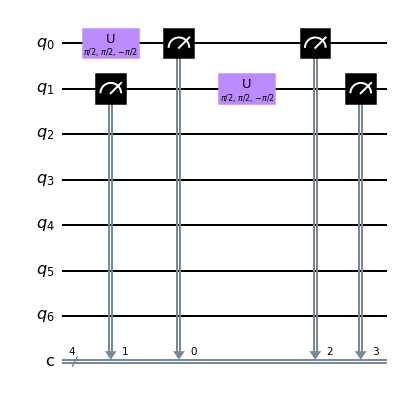

In [8]:
circuits_qndmt = qndmt.circuits()
print( len(circuits_qndmt) )
circuits_qndmt[300].draw(output='mpl')

In [9]:
circuits_qndmt[200].name

'circuit_mpt_2_1_13_1_[0,1]'

In [10]:
job_manager = IBMQJobManager()
# job = job_manager.run( transpile( circuits_qndmt, backend ) , backend=backend, shots=2**13 )
# job.statuses() 

In [12]:
# job_id = job.job_set_id()
# job_id = 'ef39fb8f4fd446fba4c1fad211088c80-16604276073751485' #average
# job_id = 'bd4971f570b54e15b9b8da6a4709225e-16623948192925158' #good
# job_id = '0f8f7f6646b3401090ae6c7bd7105c76-16624030156897843'
# job_id = 'c66172beb6804143b33df09a3fe30b15-1662403052825481'
# job_id = '1ca29bb989894ebda13142e336b06cb3-1662403178554593'
##########
job_id ='dd9ac9207a4d4ab6a362b60b21281d5f-16624902588081162'
job_id 

'dd9ac9207a4d4ab6a362b60b21281d5f-16624902588081162'

In [13]:
job = job_manager.retrieve_job_set( job_id, provider )

In [14]:
results = job.results().combine_results()

In [15]:
# job = simulator.run( circuits_qndmt, noise_model=noise_model, shots=2**13  )
# results = job.result()

In [25]:
choi_single, choi_double, gateset  = qndmt.fit( results, paralell=True, gate_set=True ) 

In [26]:
num_qubits    = qndmt._num_qubits
parall_qubits = qndmt._parall_qubits

print( num_qubits )
print( parall_qubits )

7
[[(0, 1)], [(1, 2)], [(1, 3)], [(3, 5)], [(4, 5)], [(5, 6)], [(0, 2)], [(0, 3)], [(2, 3)], [(1, 5)], [(3, 4)], [(3, 6)], [(4, 6)]]


In [27]:
quantities = []
for k in range(num_qubits):
    quantities.append( Quantities( choi_single[k][0], choi_single[k][1] ) )

quantities_2 = []
cros_quantities = []
for i in range(len(parall_qubits)):
    for j in range(len(parall_qubits[i])):
        k = parall_qubits[i][j][0]
        l = parall_qubits[i][j][1]
        cros_quantities.append( Cross_Quantities( choi_single[k][0], choi_single[k][1],
                                                  choi_single[l][0], choi_single[l][1],
                                                  choi_double[i][j][0], choi_double[i][j][1]
                                                )  )
        quantities_2.append( Quantities( choi_double[i][j][0], choi_double[i][j][1] ) )

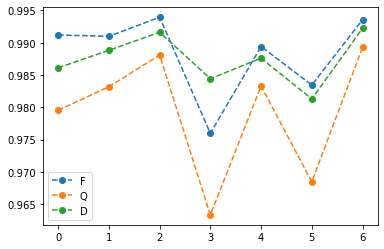

In [28]:
plt.plot( quantities, '--o' )
plt.legend( ['F','Q', 'D'] )

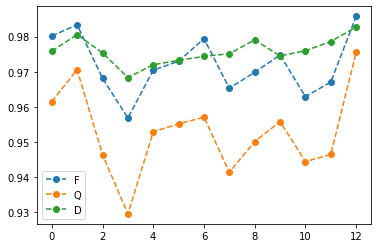

In [29]:
plt.plot( quantities_2, '--o' )
plt.legend( ['F','Q', 'D'] )

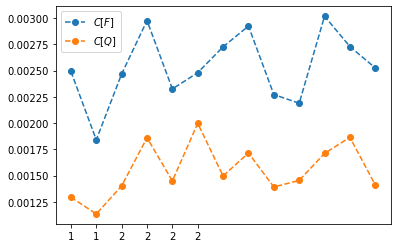

In [30]:
plt.plot( np.array(cros_quantities), '--o' )
plt.xticks([0,1,2,3,4,5], labels=[1,1,2,2,2,2])
plt.legend( ['$C[F]$', '$C[Q]$' ] )
plt.savefig( 'fig_correlation_'+job_id+'.png' )

In [31]:
import cvxpy as cp

def convex_optimization( pi, n_times=10 ):
    
    Pi0 = np.array([[1,0],[0,0]])
    Pi1 = np.array([[1,0],[0,0]])

    X = cp.Variable((2,2), hermitian=True)
    Y = cp.Variable((2,2), hermitian=True)
    constraints = [ X >> 0, X << np.eye(2), Y >> 0, Y << np.eye(2) ]

    for j in range(n_times):
        cost = cp.sum_squares( pi[:,:,0] - cp.kron( X, Pi1 ) ) + cp.sum_squares( pi[:,:,1] - cp.kron( X, np.eye(2)-Pi1 ) ) +cp.sum_squares( pi[:,:,2] - cp.kron( np.eye(2)-X, Pi1 ) ) + cp.sum_squares( pi[:,:,3] - cp.kron( np.eye(2)-X, np.eye(2)-Pi1 ) ) 
                
        prob = cp.Problem( cp.Minimize(cost), constraints)
        prob.solve()
        Pi0 = X.value

        cost = cp.sum_squares( pi[:,:,0] - cp.kron( Pi0, Y ) ) + cp.sum_squares( pi[:,:,1] - cp.kron( Pi0, np.eye(2)-Y ) ) +cp.sum_squares( pi[:,:,2] - cp.kron( np.eye(2)-Pi0, Y ) ) + cp.sum_squares( pi[:,:,3] - cp.kron( np.eye(2)-Pi0, np.eye(2)-Y ) ) 
        prob = cp.Problem( cp.Minimize(cost), constraints)
        prob.solve()
        Pi1 = Y.value

    return Pi0, Pi1

In [35]:
funs = []

for j in range(len(parall_qubits)):

    pi00 = choi_double[j][0][0].reshape(4,4,4)

    pi0, pi1 = convex_optimization( pi00 )

    fun = ( np.linalg.norm( pi00[:,:,0] - np.kron(pi0,pi1) )**2 
            + np.linalg.norm( pi00[:,:,1] - np.kron(pi0,np.eye(2)-pi1) )**2 
            + np.linalg.norm( pi00[:,:,2] - np.kron(np.eye(2)-pi0,pi1) )**2 
            + np.linalg.norm( pi00[:,:,3] - np.kron(np.eye(2)-pi0,np.eye(2)-pi1) )**2 
            )
    funs.append( fun )

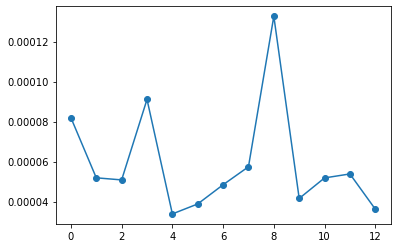

In [36]:
plt.plot( funs, '-o' )

In [37]:
funs

[8.195935684575006e-05,
 5.1903639427958344e-05,
 5.0858428814757676e-05,
 9.11126585167201e-05,
 3.385486867830481e-05,
 3.884227610139553e-05,
 4.843803877322768e-05,
 5.742939201625257e-05,
 0.000132699651232407,
 4.1586115115522296e-05,
 5.185679149807079e-05,
 5.384173634739641e-05,
 3.624340065939444e-05]